In [1]:
import numpy as np
import sympy as sp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
#sp.init_session()

(2, 1)


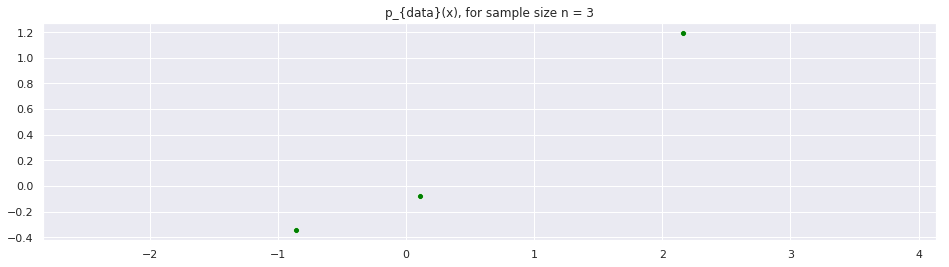

In [2]:
latent_dim = 1
data_dim = 2
color_true = 'green'

# Models parameters
w_true = np.array([[2], [3]])
print(w_true.shape)
psi_true = np.diag([0.2, 0.8])

def generate_synthetic_2d(w=w_true, psi=psi_true, n=10):
    # Sample latent variable, noise -> generate data
    z = np.random.normal(loc=0, scale=1, size=(n, latent_dim))
    eps = np.random.multivariate_normal(mean=np.zeros(data_dim), cov=psi, size=n)
    # Generative model
    x = np.einsum('ij,nj->ni', w, z) + eps  # WZ+eps
    return z, x

n = 3
z, x = generate_synthetic_2d(n=n)

# Plot data
fig, ax = plt.subplots(ncols=1, figsize=(16, 4))
ax = sns.scatterplot(x[:, 0], x[:, 1], ax=ax, color=color_true)
plt.axis('equal')
title = ax.set_title('p_{data}(x), for sample size n = %d' % n)

## Investigate how the parameters $\theta=w$ and $\phi$ score on the LL and the ELBO

We consider the following variational approximation: 

\begin{equation}
    q_\phi(z|x) = N(\phi_1^T x, \phi_2^2)
\end{equation}

i.e. we assume a unique linear layer in the decoder, and an isotropic approximation.

The log-likelihood writes:

\begin{align*}
    L 
    &= -\frac{1}{2}\log(2\pi) - \frac{1}{2}\log\left(|WW^T+\Psi|\right) - \frac{1}{2} \mathbb{E}_{p_{data}(x)} \left(x^T(WW^T+\Psi)^{-1} x\right)
\end{align*}

In [18]:
phi22 = sp.symbols('phi22')
phi1 = sp.MatrixSymbol('phi1', 2, 1)
x_i = sp.MatrixSymbol('x_i', 2, 1)
w = sp.MatrixSymbol('w', 2, 1)  # 2 rows 1 columns! and model writes
psi = sp.MatrixSymbol('psi', 2, 2)

x_cov = sp.MatMul(w, w.T) + psi
z_posterior_var = 1. / sp.MatMul(sp.MatMul(w.T, sp.Inverse(psi)), w)[0, 0]

ll_cst = - 1. / 2. * sp.log(2 * sp.pi)
ll_det = - 1. / 2. * sp.log(sp.det(x_cov))
ll_var = - 1. / 2. * sp.MatMul(sp.MatMul(x_i.T, sp.Inverse(x_cov)), x_i)

loglikelihood_i = ll_cst + ll_det + ll_var[0, 0]
#function_loglikelihood_i = lambda x_elt: loglikelihood_i.subs(x_i, x_elt)
#loglikelihood = sp.sum([ for x_elt in x])
loglikelihood = np.mean([loglikelihood_i.subs({x_i: sp.Matrix(x_elt)}) for x_elt in x])

In [19]:
print(loglikelihood)

(-2.70743509939279*((w*w.T + psi)^-1)[0, 0] - 1.43397603888341*((w*w.T + psi)^-1)[0, 1] - 1.43397603888341*((w*w.T + psi)^-1)[1, 0] - 0.7755498432345*((w*w.T + psi)^-1)[1, 1] - 1.5*log(2*pi) - 1.5*log(Determinant(w*w.T + psi)))/3


In [31]:
expr = loglikelihood
print(type(expr))

print('\n')

dexpr_w = sp.diff(expr, w)
print(dexpr_w)

dexpr_psi = sp.diff(expr, psi)
print(dexpr_psi)

argmaxima = sp.solve(dexpr_psi, psi)
#argmaxima = sp.solve([dexpr_w, dexpr_psi], [w, psi])

<class 'sympy.core.mul.Mul'>


-0.5*Determinant(w*w.T + psi)**(-1)*Derivative(Determinant(w*w.T + psi), w)
-0.5*Determinant(w*w.T + psi)**(-1)*Derivative(Determinant(w*w.T + psi), psi)


TypeError: Mix of Matrix and Scalar symbols

In [ ]:
def argmaxima_likelihood(expr=loglikelihood):
    dexpr_w = sp.diff(expr, w)
    dexpr_w = sp.simplify(dexpr_w)
    argmaxima = sp.solve(dexpr_w, w)
    return argmaxima

def maxima_likelihood(expr=loglikelihood, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    argmaxima = argmaxima_likelihood(expr, x)
    maxima = [expr.subs(w, argmax) for argmax in argmaxima]
    maxima = [sp.N(sp.simplify(maximum)) for maximum in maxima]
    return maxima


The KL between the approximate posterior and the true posterior:

\begin{align*}
    KL\left(q(z|x) || p(z | x)\right) 
 &= KL\left( 
 N(\phi_1^T x, \phi_2^2)
 || 
 N \left(
\Sigma W^T\Psi^{-1}x, \Sigma = (I+W^T\Psi^{-1} W)^{-1}
\right)
\right)
\\
 &= \frac{1}{2}\log\frac{(I+W^T\Psi^{-1} W)^{-1}}{\phi_2^2} + \frac{\phi_2^2}{2(I+W^T\Psi^{-1} W)^{-1} } + \frac{(\phi_1^T x - \Sigma W^T\Psi^{-1}x)^2}{2(I+W^T\Psi^{-1} W)^{-1} } - \frac{1}{2}
\end{align*}

We also compute the KL between the approximate posterior and the prior:

\begin{align*}
KL\left(q(z|x) || p(z)\right) 
= KL\left(N(\phi_1^T x, \phi_2^2) || N(0, 1) \right) = \frac{1}{2} \log\frac{1}{\phi_2^2} + \frac{\phi_2^2 + (\phi_1^T x)^2}{2} - \frac{1}{2}
\end{align*}



In [12]:
kl_cst = - 1. /2.
kl_det = 1. / 2. * sp.log(z_posterior_var / phi22)
kl_frac_num = phi22 + (z_posterior_var * sp.MatMul(w.T, sp.MatMul(sp.Inverse(psi), x_i)) - sp.MatMul(phi1.T, x_i))[0, 0] ** 2
kl_frac_denom = 2 * z_posterior_var
klposterior_i =  kl_cst + kl_det + kl_frac_num / kl_frac_denom

elbo_i = loglikelihood_i - klposterior_i

klposterior = np.mean([klposterior_i.subs({x_i: sp.Matrix(x_elt)}) for x_elt in x])
elbo = np.mean([elbo_i.subs({x_i: sp.Matrix(x_elt)}) for x_elt in x])

In [13]:
elbo

(-(phi22 + (-2.16169393014758*phi1[0, 0] - 1.19393208513112*phi1[1, 0] + 1.0*(2.16169393014758*(psi^-1)[0, 0]*w[0, 0] + 1.19393208513112*(psi^-1)[0, 1]*w[0, 0] + 2.16169393014758*(psi^-1)[1, 0]*w[1, 0] + 1.19393208513112*(psi^-1)[1, 1]*w[1, 0])/(((psi^-1)[0, 0]*w[0, 0] + (psi^-1)[1, 0]*w[1, 0])*w[0, 0] + ((psi^-1)[0, 1]*w[0, 0] + (psi^-1)[1, 1]*w[1, 0])*w[1, 0]))**2)*(0.5*((psi^-1)[0, 0]*w[0, 0] + (psi^-1)[1, 0]*w[1, 0])*w[0, 0] + 0.5*((psi^-1)[0, 1]*w[0, 0] + (psi^-1)[1, 1]*w[1, 0])*w[1, 0]) - (phi22 + (-0.107511772375351*phi1[0, 0] + 0.0782137374865922*phi1[1, 0] + 1.0*(0.107511772375351*(psi^-1)[0, 0]*w[0, 0] - 0.0782137374865922*(psi^-1)[0, 1]*w[0, 0] + 0.107511772375351*(psi^-1)[1, 0]*w[1, 0] - 0.0782137374865922*(psi^-1)[1, 1]*w[1, 0])/(((psi^-1)[0, 0]*w[0, 0] + (psi^-1)[1, 0]*w[1, 0])*w[0, 0] + ((psi^-1)[0, 1]*w[0, 0] + (psi^-1)[1, 1]*w[1, 0])*w[1, 0]))**2)*(0.5*((psi^-1)[0, 0]*w[0, 0] + (psi^-1)[1, 0]*w[1, 0])*w[0, 0] + 0.5*((psi^-1)[0, 1]*w[0, 0] + (psi^-1)[1, 1]*w[1, 0])*w[1,

TODO: Need the expression wrt sigma2 for the exact computations.

In [14]:
def argmaxima(expr=loglikelihood):
    dexpr_phi1_phi22 = sp.diff(expr, phi1, phi22)
    dexpr_phi1_phi22 = sp.simplify(dexpr_phi1_phi22)
    argmaxima = sp.solve(dexpr_phi1_phi22, phi1, phi22)
    return argmaxima

def maxima(expr=loglikelihood, x=None):
    if x is not None:
        sigma2 = np.mean(x**2)
        expr = expr.subs(sig2, sigma2)
    argmaxima = argmaxima_likelihood(expr, x)
    maxima = [expr.subs(w, argmax) for argmax in argmaxima]
    maxima = [sp.N(sp.simplify(maximum)) for maximum in maxima]
    return maxima

In [15]:
argmaxima(-klposterior)

[]